# LeNet5 - Tensorflow/Keras - Mnist

> This notebook is supposed to work on Google Collab. Here is the Cuda version and the Tensorflow/Keras version.

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [2]:
!pip freeze | grep -e "tensorflow==" -e "keras=="

keras==2.9.0
tensorflow==2.9.2


In [3]:
import tensorflow as tf

from sklearn.model_selection import train_test_split

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print(f'Found GPU: {device_name}')

Found GPU: /device:GPU:0


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import numpy as np

## Load and prepare data

In [7]:
# Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [8]:
# Normalize pixel values to be between 0 and 1
x_train  = x_train / 255.0
x_test= x_test / 255.0

In [9]:
# Add channel dimension

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
np.shape(x_train)

(60000, 28, 28, 1)

In [10]:
# Fixing seed for Python, NumPy, and TensorFlow
seed = 0
tf.keras.utils.set_random_seed(seed)

In [11]:
# Split train val
x_train,x_val,y_train, y_val = train_test_split(x_train,y_train,test_size=10000,random_state=0)

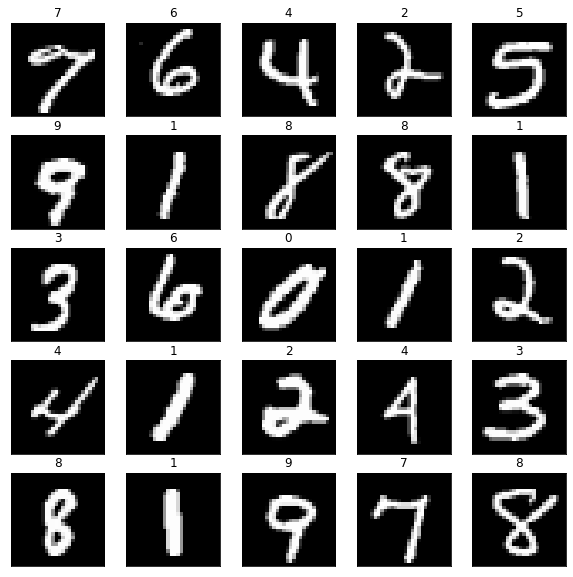

In [12]:
# Plot grid with first 25 training images with their corresponding label
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(y_train[i])
plt.show()

## Defining a training class

In [13]:
class Trainer:
    def __init__(self, model, loss_function, optimizer):
        self._model = model
        self._loss_function = loss_function
        self._optimizer = optimizer
        # Metrics
        self._train_loss = tf.keras.metrics.Mean()
        self._val_loss = tf.keras.metrics.Mean()
        self._train_acc = tf.keras.metrics.SparseCategoricalAccuracy()
        self._val_acc = tf.keras.metrics.SparseCategoricalAccuracy()
        # History
        self._train_loss_h = []
        self._train_acc_h = []
        self._val_loss_h = []
        self._val_acc_h = []
    
    def fit(self, x_train, y_train, x_val, y_val, epochs, verbose=True):
        """
        Cette méthode permet d'entraîner le modèle sur x_train et y_train pour
        un certain nombre d'epochs
        """
        for epoch in range(epochs):
            # Reset metrics for each epoch
            self._train_loss.reset_states()
            self._train_acc.reset_states()
            self._val_acc.reset_states()
            self._val_loss.reset_states()

            # Train the model for one epoch
            self._train_step(x_train,y_train)
            # Perform a validation step
            self._eval_step(x_val,y_val)

            # Update history
            self._train_loss_h.append(self._train_loss.result())
            self._train_acc_h.append(self._train_acc.result() * 100.)
            self._val_loss_h.append(self._val_loss.result())
            self._val_acc_h.append(self._val_acc.result() * 100.)
            if verbose:
                print((f'Epoch {epoch+1}/{epochs} - '
                       f'loss: {self._train_loss_h[-1]:.6f} - '
                       f'train acc: {self._train_acc_h[-1]:.2f}% - '
                       f'val acc: {self._val_acc_h[-1]:.2f}%'))
        
    def plot_history(self):
        plt.figure(figsize=(10,10))
        plt.subplot(2, 1, 1)
        plt.plot(self._train_loss_h, label='train')
        plt.plot(self._val_loss_h, label='val')
        plt.legend()
        plt.title('Loss')
        plt.subplot(2, 1, 2)
        plt.plot(self._train_acc_h, label='train')
        plt.plot(self._val_acc_h, label='val')
        plt.legend()
        plt.title('Acc')
        plt.show()

    def predict(self, x_test):
        """
        Cette méthode doit retourner les prédiction du modèle pour les données 
        x_test
        """
        return self._model(x_test)
        
    @tf.function
    def _train_step(self, x, y):
        """
        Cette méthode doit performer une étape d'entrainement, c'est à dire :
            - Feed forward de x dans le modèle
            - Calcul de la loss entre y et les prédictions du modèle
            - Mise à jour des métriques self._train_acc et self._train_loss,
              cf https://keras.io/api/metrics/
            - Calcul du gradient
            - Application du gradient par l'optimizer
        """
        with tf.GradientTape() as tape :
          # Forward propagation des données x dans le modèle pour obtenir les prédictions
          predictions = self._model(x)
          # Calcul de la loss entre les target sy et les prédictions obtenues
          loss = self._loss_function(y, predictions)
          # Calcul automatique du gradient par TensorFlow sur les paramètres du modèle
          # (model.trainable_variables)
          self._train_acc.update_state(y, predictions)
          self._train_loss.update_state(loss)
        
        gradients = tape.gradient(loss, self._model.trainable_variables)
        # Mise à jour des paramètres en utilisant l’algorithme d’optimisation
        # (backward propagation)
        self._optimizer.apply_gradients(zip(gradients, self._model.trainable_variables))

    @tf.function
    def _eval_step(self, x, y):
        """
        Cette méthode doit performer une étape de validation :
            - Feed forward de x dans le modèle
            - Calcul de la loss entre y et les prédictions du modèle
            - Mise à jour des métriques self._val_acc et self._val_loss,
              cf https://keras.io/api/metrics/
        """
        predictions = self._model(x)
        # Calcul de la loss entre les target sy et les prédictions obtenues
        loss = self._loss_function(y, predictions)
        # Calcul automatique du gradient par TensorFlow sur les paramètres du modèle
        # (model.trainable_variables)
        self._val_acc.update_state(y, predictions)
        self._val_loss.update_state(loss)

## Building architecture then model

### Training without Batch size

Epoch 1/100 - loss: 2.303835 - train acc: 8.82% - val acc: 56.44%
Epoch 2/100 - loss: 2.064600 - train acc: 56.85% - val acc: 71.48%
Epoch 3/100 - loss: 1.800587 - train acc: 71.93% - val acc: 78.10%
Epoch 4/100 - loss: 1.519193 - train acc: 77.90% - val acc: 81.00%
Epoch 5/100 - loss: 1.250211 - train acc: 81.22% - val acc: 82.28%
Epoch 6/100 - loss: 1.011536 - train acc: 82.51% - val acc: 83.78%
Epoch 7/100 - loss: 0.812369 - train acc: 83.75% - val acc: 84.50%
Epoch 8/100 - loss: 0.667350 - train acc: 84.71% - val acc: 85.41%
Epoch 9/100 - loss: 0.565675 - train acc: 85.36% - val acc: 86.60%
Epoch 10/100 - loss: 0.494588 - train acc: 86.48% - val acc: 87.26%
Epoch 11/100 - loss: 0.449687 - train acc: 87.34% - val acc: 88.14%
Epoch 12/100 - loss: 0.418643 - train acc: 87.99% - val acc: 88.46%
Epoch 13/100 - loss: 0.397184 - train acc: 88.24% - val acc: 89.11%
Epoch 14/100 - loss: 0.380391 - train acc: 88.91% - val acc: 89.60%
Epoch 15/100 - loss: 0.365209 - train acc: 89.32% - val ac

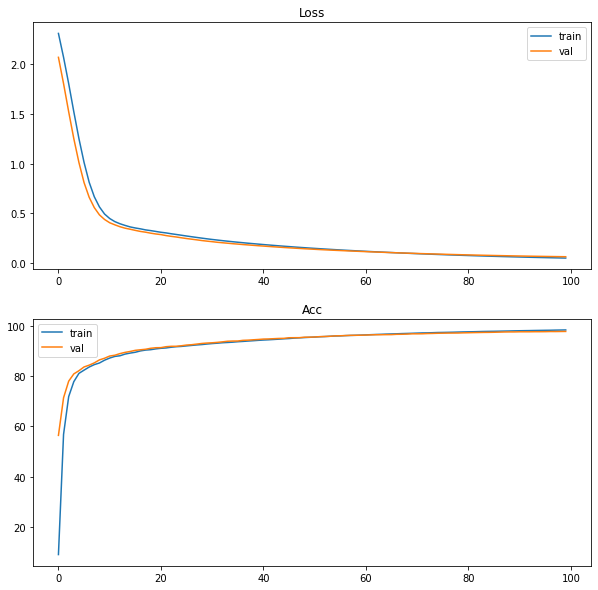

Test accuracy: 98.09%


In [14]:
# Define model, for a fully-connected network the input must be properly adapted
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(28, 5, strides=(1, 1), padding="valid", activation=None),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=.65, input_shape=(2,)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

# Set hyperparameters
loss_function=tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
epochs = 100

# Initialize trainer
mnist_fc_trainer = Trainer(model=model,
                           loss_function=loss_function,
                           optimizer=optimizer)
# Train model
mnist_fc_trainer.fit(x_train, y_train, x_val, y_val, epochs)

# Plot training history
mnist_fc_trainer.plot_history()

# Evaluate on test set
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_acc')
predictions = mnist_fc_trainer.predict(x_test)
test_acc(y_test, predictions)
print(f'Test accuracy: {test_acc.result()*100.:.2f}%')

### Training with Batch size

In [15]:
class Trainer:
    def __init__(self, model, loss_function, optimizer):
        self._model = model
        self._loss_function = loss_function
        self._optimizer = optimizer
        # Metrics
        self._train_loss = tf.keras.metrics.Mean()
        self._val_loss = tf.keras.metrics.Mean()
        self._train_acc = tf.keras.metrics.SparseCategoricalAccuracy()
        self._val_acc = tf.keras.metrics.SparseCategoricalAccuracy()
        # History
        self._train_loss_h = []
        self._train_acc_h = []
        self._val_loss_h = []
        self._val_acc_h = []
    
    def fit(self, x_train, y_train, x_val, y_val, epochs, batch_size, verbose=True):
        """
        Cette méthode permet d'entraîner le modèle sur x_train et y_train pour
        un certain nombre d'epochs
        """
        split_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
        for epoch in range(epochs):
            # Reset metrics for each epoch
            self._train_loss.reset_states()
            self._train_acc.reset_states()
            self._val_acc.reset_states()
            self._val_loss.reset_states()

            for x_batch, y_batch in split_ds:
              # Train the model for one epoch
              self._train_step(x_batch,y_batch)
            # Perform a validation step
            self._eval_step(x_val,y_val)

            # Update history
            self._train_loss_h.append(self._train_loss.result())
            self._train_acc_h.append(self._train_acc.result() * 100.)
            self._val_loss_h.append(self._val_loss.result())
            self._val_acc_h.append(self._val_acc.result() * 100.)
            if verbose:
                print((f'Epoch {epoch+1}/{epochs} - '
                       f'loss: {self._train_loss_h[-1]:.6f} - '
                       f'train acc: {self._train_acc_h[-1]:.2f}% - '
                       f'val acc: {self._val_acc_h[-1]:.2f}%'))
        
    def plot_history(self):
        plt.figure(figsize=(10,10))
        plt.subplot(2, 1, 1)
        plt.plot(self._train_loss_h, label='train')
        plt.plot(self._val_loss_h, label='val')
        plt.legend()
        plt.title('Loss')
        plt.subplot(2, 1, 2)
        plt.plot(self._train_acc_h, label='train')
        plt.plot(self._val_acc_h, label='val')
        plt.legend()
        plt.title('Acc')
        plt.show()

    def predict(self, x_test):
        """
        Cette méthode doit retourner les prédiction du modèle pour les données 
        x_test
        """
        return self._model(x_test)
        
    @tf.function
    def _train_step(self, x, y):
        """
        Cette méthode doit performer une étape d'entrainement, c'est à dire :
            - Feed forward de x dans le modèle
            - Calcul de la loss entre y et les prédictions du modèle
            - Mise à jour des métriques self._train_acc et self._train_loss,
              cf https://keras.io/api/metrics/
            - Calcul du gradient
            - Application du gradient par l'optimizer
        """
        with tf.GradientTape() as tape :
          # Forward propagation des données x dans le modèle pour obtenir les prédictions
          predictions = self._model(x)
          # Calcul de la loss entre les target sy et les prédictions obtenues
          loss = self._loss_function(y, predictions)
          # Calcul automatique du gradient par TensorFlow sur les paramètres du modèle
          # (model.trainable_variables)
          self._train_acc.update_state(y, predictions)
          self._train_loss.update_state(loss)
        
        gradients = tape.gradient(loss, self._model.trainable_variables)
        # Mise à jour des paramètres en utilisant l’algorithme d’optimisation
        # (backward propagation)
        self._optimizer.apply_gradients(zip(gradients, self._model.trainable_variables))

    @tf.function
    def _eval_step(self, x, y):
        """
        Cette méthode doit performer une étape de validation :
            - Feed forward de x dans le modèle
            - Calcul de la loss entre y et les prédictions du modèle
            - Mise à jour des métriques self._val_acc et self._val_loss,
              cf https://keras.io/api/metrics/
        """
        predictions = self._model(x)
        # Calcul de la loss entre les target sy et les prédictions obtenues
        loss = self._loss_function(y, predictions)
        # Calcul automatique du gradient par TensorFlow sur les paramètres du modèle
        # (model.trainable_variables)
        self._val_acc.update_state(y, predictions)
        self._val_loss.update_state(loss)

Epoch 1/25 - loss: 0.290888 - train acc: 91.48% - val acc: 96.61%
Epoch 2/25 - loss: 0.086558 - train acc: 97.47% - val acc: 97.93%
Epoch 3/25 - loss: 0.050546 - train acc: 98.46% - val acc: 98.17%
Epoch 4/25 - loss: 0.030295 - train acc: 99.11% - val acc: 98.20%
Epoch 5/25 - loss: 0.021484 - train acc: 99.33% - val acc: 97.94%
Epoch 6/25 - loss: 0.016974 - train acc: 99.48% - val acc: 97.64%
Epoch 7/25 - loss: 0.017773 - train acc: 99.37% - val acc: 98.20%
Epoch 8/25 - loss: 0.011426 - train acc: 99.61% - val acc: 98.43%
Epoch 9/25 - loss: 0.006864 - train acc: 99.80% - val acc: 98.35%
Epoch 10/25 - loss: 0.005132 - train acc: 99.85% - val acc: 98.29%
Epoch 11/25 - loss: 0.004597 - train acc: 99.86% - val acc: 98.62%
Epoch 12/25 - loss: 0.009321 - train acc: 99.67% - val acc: 98.17%
Epoch 13/25 - loss: 0.008420 - train acc: 99.72% - val acc: 98.58%
Epoch 14/25 - loss: 0.008551 - train acc: 99.72% - val acc: 98.32%
Epoch 15/25 - loss: 0.005862 - train acc: 99.78% - val acc: 98.47%
Epoc

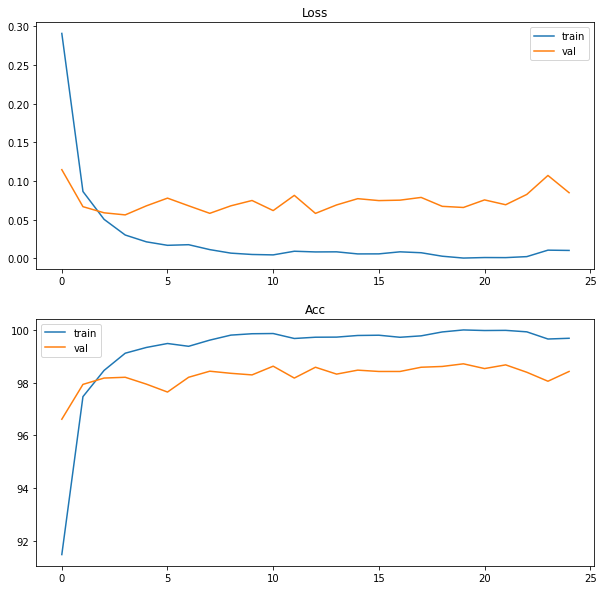

Test accuracy: 98.52%


In [16]:
# Define model, for a fully-connected network the input must be properly adapted
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(28, 5, strides=(1, 1), padding="valid", activation=None),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=.55, input_shape=(2,)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

# Set hyperparameters
loss_function=tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
epochs = 25

# Initialize trainer
mnist_fc_trainer = Trainer(model=model,
                           loss_function=loss_function,
                           optimizer=optimizer)
# Train model
%time mnist_fc_trainer.fit(x_train, y_train, x_val, y_val, epochs, batch_size=256)

# Plot training history
mnist_fc_trainer.plot_history()

# Evaluate on test set
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_acc')
predictions = mnist_fc_trainer.predict(x_test)
test_acc(y_test, predictions)
print(f'Test accuracy: {test_acc.result()*100.:.2f}%')

---
# LetNet evolution to classify Fashion MNIST data


In [17]:
# Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [18]:
# Normalize pixel values to be between 0 and 1
x_train  = x_train / 255.0
x_test= x_test / 255.0

In [19]:
# Add channel dimension
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
np.shape(x_train)

(60000, 28, 28, 1)

In [20]:
# Split train val
x_train,x_val,y_train, y_val = train_test_split(x_train,y_train,test_size=10000,random_state=0)

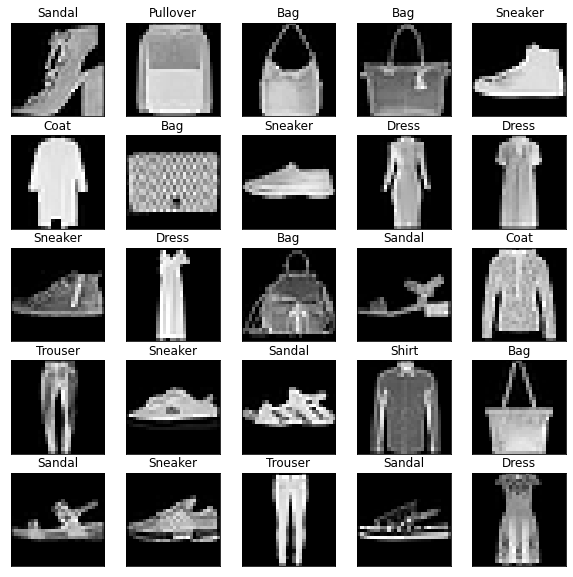

In [21]:
# Plot grid with first 25 training images with their corresponding label
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(class_names[y_train[i]])
plt.show()

Epoch 1/25 - loss: 0.566524 - train acc: 79.84% - val acc: 86.36%
Epoch 2/25 - loss: 0.357952 - train acc: 87.19% - val acc: 88.31%
Epoch 3/25 - loss: 0.296886 - train acc: 89.11% - val acc: 89.18%
Epoch 4/25 - loss: 0.256222 - train acc: 90.62% - val acc: 89.80%
Epoch 5/25 - loss: 0.223199 - train acc: 91.77% - val acc: 90.10%
Epoch 6/25 - loss: 0.192717 - train acc: 92.97% - val acc: 90.42%
Epoch 7/25 - loss: 0.165476 - train acc: 93.98% - val acc: 90.91%
Epoch 8/25 - loss: 0.143013 - train acc: 94.90% - val acc: 91.09%
Epoch 9/25 - loss: 0.125913 - train acc: 95.47% - val acc: 91.05%
Epoch 10/25 - loss: 0.112805 - train acc: 95.91% - val acc: 90.73%
Epoch 11/25 - loss: 0.103440 - train acc: 96.19% - val acc: 90.84%
Epoch 12/25 - loss: 0.091608 - train acc: 96.61% - val acc: 90.64%
Epoch 13/25 - loss: 0.077762 - train acc: 97.08% - val acc: 89.62%
Epoch 14/25 - loss: 0.069133 - train acc: 97.48% - val acc: 90.35%
Epoch 15/25 - loss: 0.060394 - train acc: 97.77% - val acc: 90.47%
Epoc

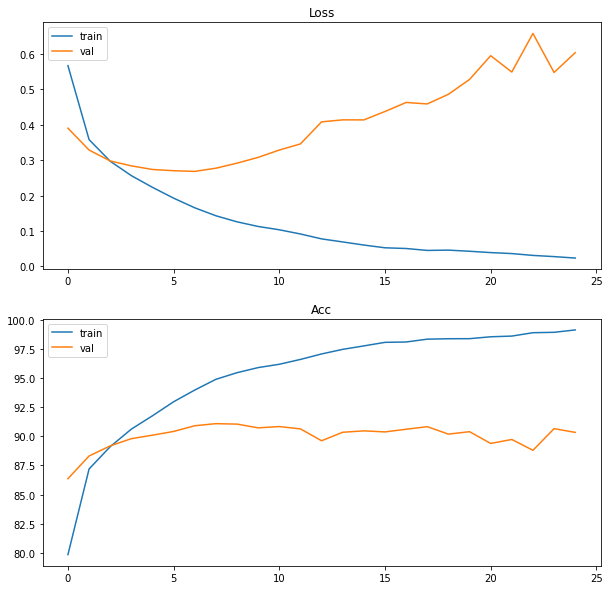

Test accuracy: 89.73%


In [22]:
# Define model, for a fully-connected network the input must be properly adapted
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(28, 5, strides=(1, 1), padding="valid", activation=None),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

# Set hyperparameters
loss_function=tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
epochs = 25

# Initialize trainer
mnist_fc_trainer = Trainer(model=model,
                           loss_function=loss_function,
                           optimizer=optimizer)
# Train model
mnist_fc_trainer.fit(x_train, y_train, x_val, y_val, epochs, batch_size=256)

# Plot training history
mnist_fc_trainer.plot_history()

# Evaluate on test set
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_acc')
predictions = mnist_fc_trainer.predict(x_test)
test_acc(y_test, predictions)
print(f'Test accuracy: {test_acc.result()*100.:.2f}%')

## Changing the architecture to manage differently the input

Epoch 1/25 - loss: 0.798665 - train acc: 71.77% - val acc: 79.19%
Epoch 2/25 - loss: 0.522079 - train acc: 81.07% - val acc: 83.21%
Epoch 3/25 - loss: 0.470240 - train acc: 83.10% - val acc: 84.22%
Epoch 4/25 - loss: 0.442589 - train acc: 84.12% - val acc: 85.01%
Epoch 5/25 - loss: 0.423524 - train acc: 84.70% - val acc: 85.64%
Epoch 6/25 - loss: 0.408492 - train acc: 85.27% - val acc: 85.93%
Epoch 7/25 - loss: 0.396809 - train acc: 85.70% - val acc: 86.18%
Epoch 8/25 - loss: 0.386561 - train acc: 85.99% - val acc: 86.57%
Epoch 9/25 - loss: 0.377686 - train acc: 86.21% - val acc: 86.68%
Epoch 10/25 - loss: 0.369459 - train acc: 86.51% - val acc: 87.03%
Epoch 11/25 - loss: 0.362574 - train acc: 86.75% - val acc: 87.31%
Epoch 12/25 - loss: 0.356001 - train acc: 86.98% - val acc: 87.37%
Epoch 13/25 - loss: 0.350504 - train acc: 87.22% - val acc: 87.48%
Epoch 14/25 - loss: 0.345378 - train acc: 87.43% - val acc: 87.66%
Epoch 15/25 - loss: 0.340433 - train acc: 87.57% - val acc: 87.62%
Epoc

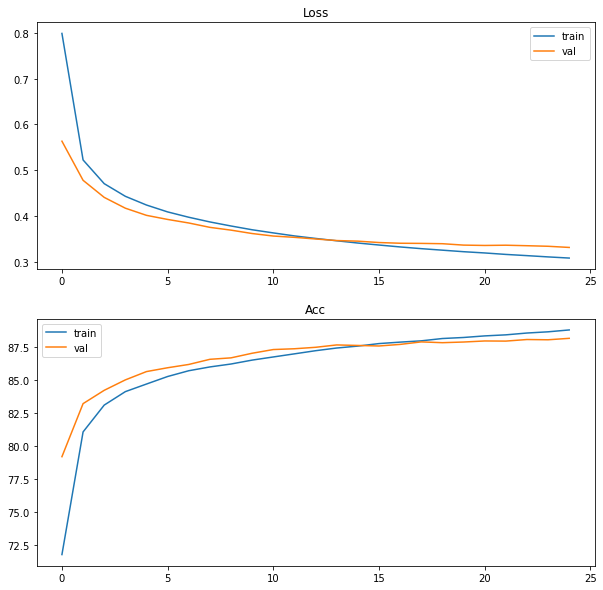

Test accuracy: 87.29%


In [23]:
# Define model, for a fully-connected network the input must be properly adapted
model = model = tf.keras.Sequential([
    tf.keras.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=10, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'),
    tf.keras.layers.Dropout(rate=.2),
    tf.keras.layers.Conv2D(filters=5, kernel_size=(3, 3), strides=(2, 2), padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'),
    tf.keras.layers.Dropout(rate=.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

# Set hyperparameters
loss_function=tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=.001)
epochs = 25

# Initialize trainer
mnist_fc_trainer = Trainer(model=model,
                           loss_function=loss_function,
                           optimizer=optimizer)
# Train model
mnist_fc_trainer.fit(x_train, y_train, x_val, y_val, epochs, batch_size=64)

# Plot training history
mnist_fc_trainer.plot_history()

# Evaluate on test set
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_acc')
predictions = mnist_fc_trainer.predict(x_test)
test_acc(y_test, predictions)
print(f'Test accuracy: {test_acc.result()*100.:.2f}%')

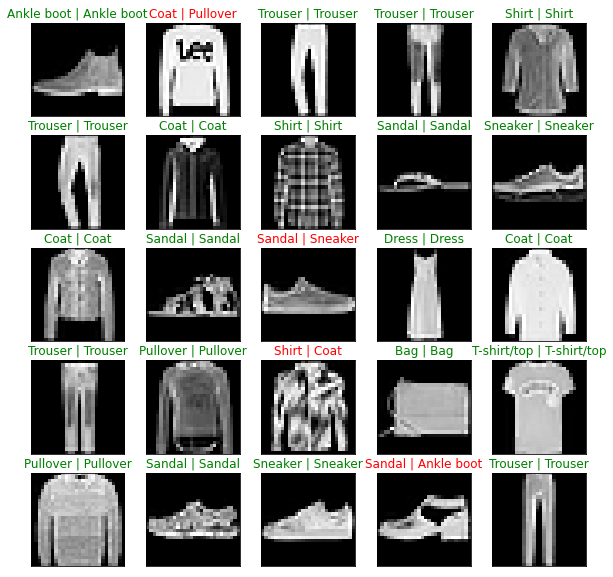

In [24]:
# Plot grid with first 25 test images with their predicted and true label
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    pred = predictions[i].numpy().argmax()
    true = y_test[i]
    color = 'green' if pred == true else 'red'
    plt.title(f'{class_names[pred]} | {class_names[true]}', color=color)
plt.show()